In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from numpy.linalg import inv
import math
from dateutil.parser import parse
import matplotlib.pyplot as plt
from dateutil.parser import parse

from scipy import stats

train_df = pd.read_csv("../input/train_1.csv")

page_details = pd.DataFrame([i.split("_")[-3:] for i in train_df["Page"]])
page_details.columns = ["project", "access", "agent"]

train_df = page_details.merge(train_df, how="inner", left_index=True, right_index=True)
enWiki_df = train_df.groupby('project').get_group('en.wikipedia.org').groupby('agent').get_group('all-agents')

def findIndex(name):
    count,__ = train_df.shape
    for i in range(count):
        if train_df.iloc[i,3] == name:
            return i

        
import pickle
def save_obj(obj, name ):
    with open('./../obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./../obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def hasNaN(u):
    row, col = u.shape
    for i in range(col):
        if np.isnan(u[0,i]):
            return True
    return False

        
bestWeeklySine = load_obj("sineall")

def NRMSE(d,p):
    # takes d desired signal and p predicted signal
    # for 1 dimensional d and p
    if(d.shape != p.shape ):
        print("Dimension mismatch!!!\n")
        exit(0)
    error = np.absolute(d - p)
    SE = np.power(error,2)
    MSE = np.mean(SE)
    var = np.mean( np.power( (d  - np.mean(d)), 2) )
    print 'var = ' ,var
    nrmse = math.sqrt(abs(MSE/var))            # doesn't work if (MSE/var) is not absoluted
    return nrmse

<IPython.core.display.Javascript object>


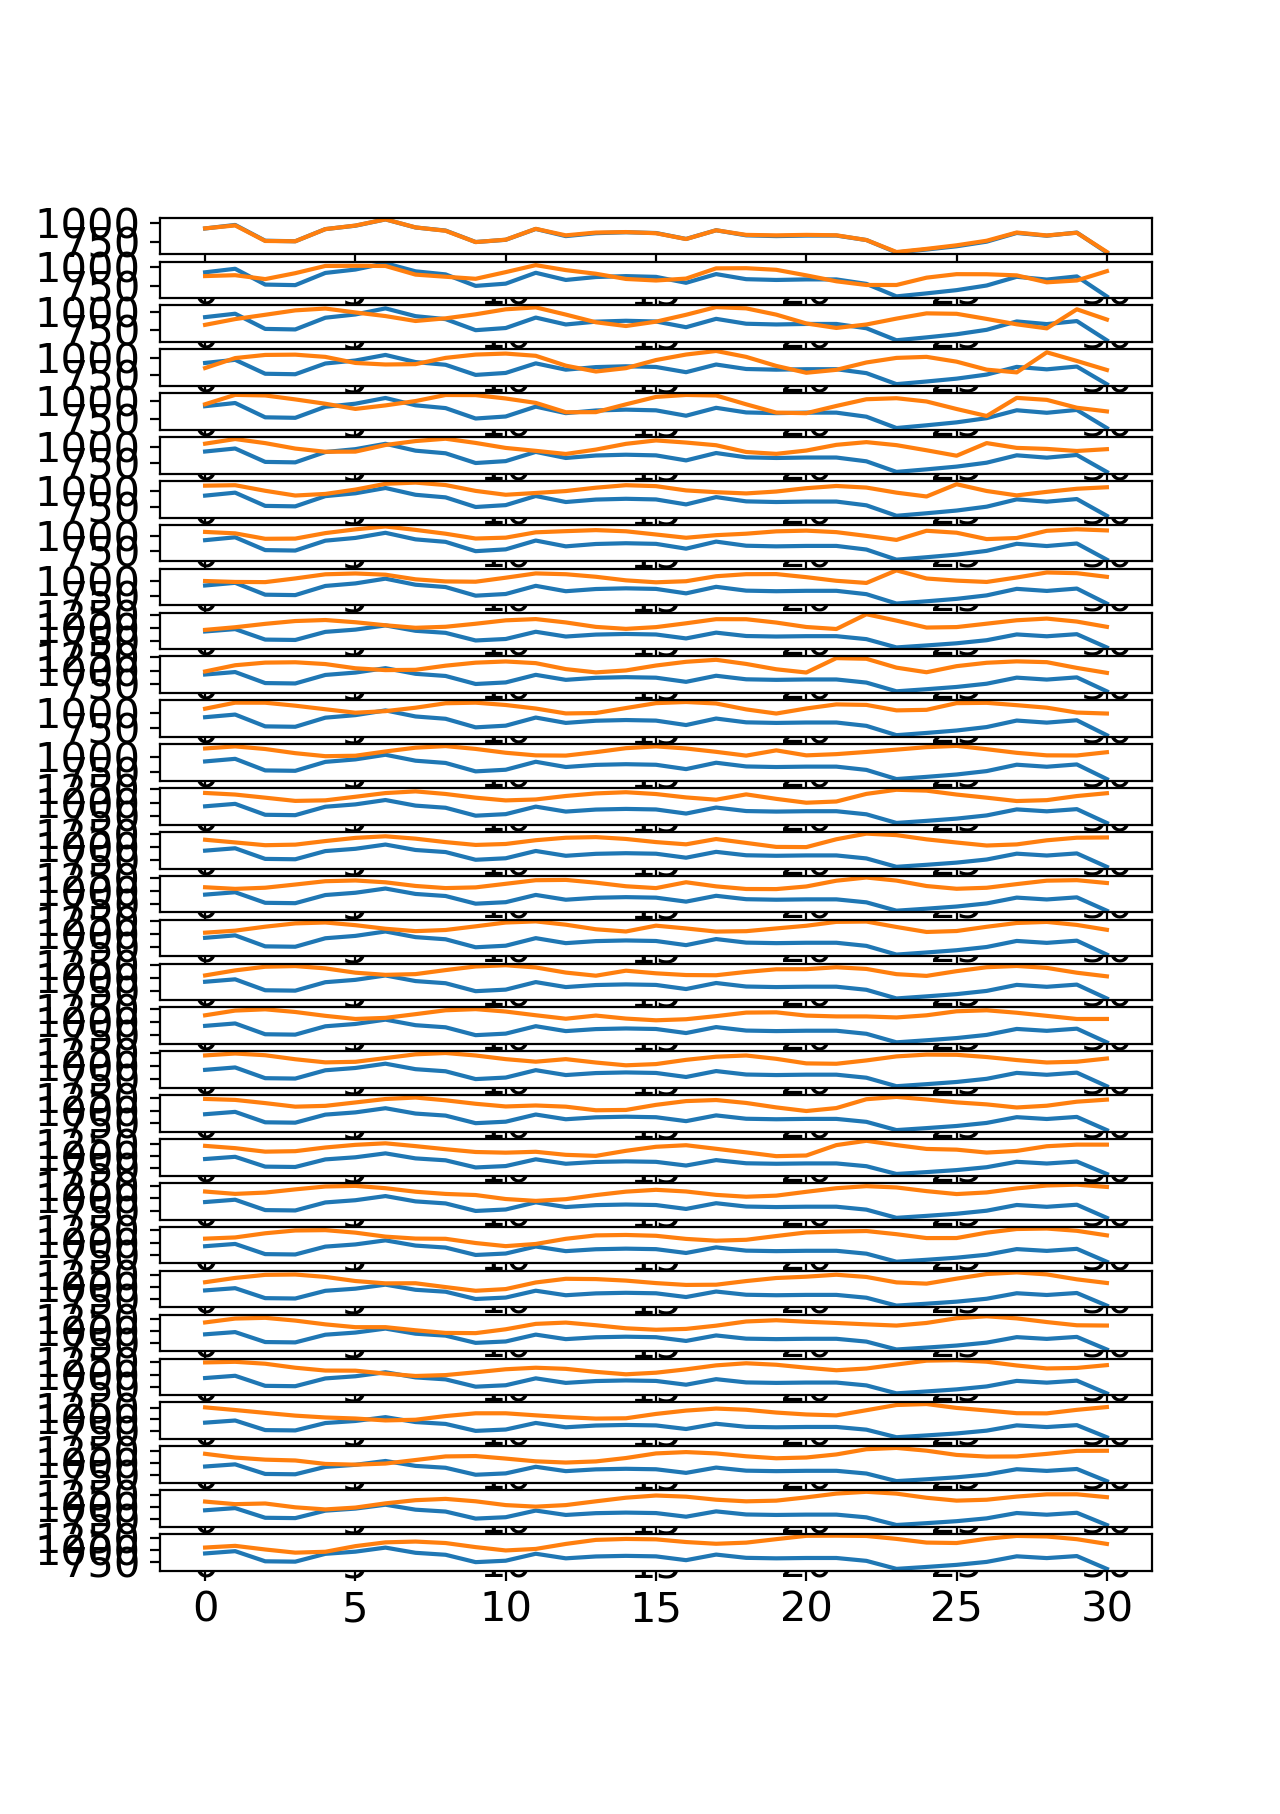

Page Name:  2002_FIFA_World_Cup_en.wikipedia.org_desktop_all-agents
Final shape of u:  (22, 550)
(519, 121)
Nrmse error:  var =  87285.70447450572
1.33145906033
var =  87285.70447450572
(-0.16892647597266372, 0.3636433311065621)
Page Name:  2002_FIFA_World_Cup_en.wikipedia.org_desktop_all-agents
Final shape of u:  (22, 550)
(518, 121)
Nrmse error:  var =  87285.70447450572
1.24419318223
var =  87285.70447450572
(-0.4061884592438255, 0.02336730026516274)
Page Name:  2002_FIFA_World_Cup_en.wikipedia.org_desktop_all-agents
Final shape of u:  (22, 550)
(517, 121)
Nrmse error:  var =  87285.70447450572
1.16651737467
var =  87285.70447450572
(-0.1702329692479087, 0.35988990553599454)
Page Name:  2002_FIFA_World_Cup_en.wikipedia.org_desktop_all-agents
Final shape of u:  (22, 550)
(516, 121)
Nrmse error:  var =  87285.70447450572
1.07535686273
var =  87285.70447450572
(0.11834033203864701, 0.5260491137473706)
Page Name:  2002_FIFA_World_Cup_en.wikipedia.org_desktop_all-agents
Final shape of u:

In [2]:
pwins =  range(31)
figureNo = 1

nrmse_arr = []

fig = plt.figure(figureNo)
for count, val in enumerate(pwins):
    crossValidation = False
    applyTanh = True
    useSine = True

    pageNo = 19
    print 'Page Name: ', enWiki_df.iloc[pageNo,3]
    num = findIndex(enWiki_df.iloc[pageNo,3])

    signal = np.matrix(train_df.iloc[num,4:].values)
    if hasNaN(signal):
         raise Exception('Some nan values found !')


    _, length = signal.shape
    ignorelen = 31                                      # Useful if you don't want to touch the testing data at all
    if not crossValidation or ignorelen == 0:
        u = signal[:]
        siglen = length
    else:
        u = signal[0,:-ignorelen]
        siglen = length - ignorelen

    minimum, maximum = signal.min(), signal.max()

    RESCALED_MAX = 2
    ROUND = 5
    powerRaise = round( math.log(RESCALED_MAX, max(train_df.iloc[num,4:].values)), ROUND)

#     print "Min:",minimum , "Max:", maximum
#     print "Power to be raised:", powerRaise

    EXPECTED_MIN =2
    shift =0 
    mean = 0
    sd = 1
    if minimum <= EXPECTED_MIN:
        shift = EXPECTED_MIN

    def inputmapping(x):
        global mean
        global sd
        scaled_shifted_sig, mean, sd = helper_inputmapping(x)
        return scaled_shifted_sig

    def helper_inputmapping(x):   # maps the input to zero mean however does not save the mean to global variable        
        scaled_sig = np.power(x.astype(float)+shift,powerRaise)
        mean = np.mean(scaled_sig)
        sd = np.std(scaled_sig.astype(float)  , ddof=1)
        if applyTanh:
            return np.tanh( (scaled_sig - mean)/sd ), mean,sd
        else:
            return   (scaled_sig - mean)/sd, mean,sd


    def invinputmapping(y):
        if applyTanh:
            return  np.power(np.arctanh(y) * sd +mean, 1/powerRaise) - shift 
        else:
            return  np.power(y * sd +mean, 1/powerRaise) - shift

    def sine(period, length):
        x = np.array(length)
        y = np.sin(2 * np.pi * x / period)
        return y


    u = inputmapping(u.astype(float))

    startIndex = bestWeeklySine[num][0]                                 # gives the starting point for sine wave with highest correlation to input signal


    sf_sin = 1.0   # 0.7 - 1.2
    if useSine:
#         print "Addtional sine signal in use"
        u = np.vstack((u,sf_sin * sine(7,range(startIndex, startIndex + siglen))))

#     print "u.shape: ",u.shape



    __, u_len =  u.shape 
    if crossValidation:
        testlen = 0
    else:
        testlen = ignorelen
    pwin = val
    if not crossValidation and testlen < pwin:
        raise Exception("Prediction window cannot be greater than the testlen itself.")
    trainlen = u_len - testlen

    def make_teachers():
        teachers = np.zeros((pwin,trainlen-pwin))
        for i in range(pwin):
            teachers[i,:] =  u[0, i+1:trainlen -(pwin)+i+1].astype(float)     # Assumption: u is already preprocessed (i.e logged and shifted) 

        return np.matrix(teachers)


    d = u[0,pwin:trainlen]   # for now lets just predict on single horizon
#     print d.shape


    try:
        corrCoeffDict = load_obj("corrCoeffDict"+str(num))
    except:
        print "Variable file not found. Calculating the correlation."
        print "Be patient! It takes quite a time."
        count,__ = train_df.shape
        corrCoeffDict = {}
        for i in range(count):
            corrCoeff,__ =  stats.pearsonr(train_df.iloc[num,4:].values, train_df.iloc[i,4:].values)
            if not np.isnan(corrCoeff) and train_df.iloc[num,3] != train_df.iloc[i,3]:
                if len(corrCoeffDict.keys()) <20:
                    corrCoeffDict[corrCoeff] = i
                elif abs(corrCoeff) > min(np.abs(corrCoeffDict.keys())):
                    if min(np.abs(corrCoeffDict.keys())) in corrCoeffDict:
                        del corrCoeffDict[ min(np.abs(corrCoeffDict.keys())) ]
                    else:
                        del corrCoeffDict[-1* min(np.abs(corrCoeffDict.keys())) ]
                    corrCoeffDict[corrCoeff] = i
        save_obj( corrCoeffDict,'corrCoeffDict'+ str(num))

#     print "Done."
    # help (np.reshape)


    useAddSig = True
    useMeanSig = False # use the average svalue of additional signals or use them independently
    sf_addSig = 0.5 #0.5 -1
    if useAddSig:
#         print "Initial shape of u: ",u.shape
        if useMeanSig:
            # Step 1: compute mean signal
            sumSig = np.zeros((siglen))
            for i in corrCoeffDict.values():
                test, _, _ = helper_inputmapping(train_df.iloc[i,4:4+siglen].values)
                sumSig  += test
            # Step 2: reset the dimension of u 
            if useSine:
                u = np.reshape(u[:2,:],(2,siglen))             # if u already has multiple helper signal delete them before adding newer ones
                print "Using sine signal"
                print u.shape
            else:
                u = np.reshape(u[0,:],(1,siglen))
            #Step 3: stack the mean of addtional signal

            u = np.vstack((u, sf_addSig* sumSig/len(corrCoeffDict)))                 # !!!!!!!!!!!!!
            print "Mean of additional signals is used"
    #         figureNo += 1
    #         plt.figure(figureNo)
    #         plt.plot(u[0,:].T)
    #         plt.plot(u[1,:].T)
    #         if useSine:
    #             plt.plot(u[2,:].T)
        else:
            # Step 1: reset the dimension of u 
            if useSine:
                u = np.reshape(u[:2,:],(2,siglen))             # if u already has multiple helper signal delete them before adding newer ones
#                 print u.shape
#                 print "Using sine signal"
            else:
                u = np.reshape(u[0,:],(1,siglen))
            #Step 2: stack the addtional signals
            for _,j in corrCoeffDict.iteritems():

                u = np.vstack((u, sf_addSig* 1/len(corrCoeffDict) * helper_inputmapping(train_df.iloc[j,4:4+siglen].values.astype(float))[0][:siglen]))     #!!!!!!!
#             print "Each additional signals are used independently"

    #         figureNo +=1
    #         plt.figure(figureNo)
    #         count =0
    #         plt.plot(u[count,:].T)
    #         if useSine:
    #             count+=2
    #         for _,_ in corrCoeffDict.iteritems():
    #             plt.plot(20.0 *u[count,:].T)
    #             count+=1
        print "Final shape of u: ", u.shape

    else:
        if useSine:
            u = np.reshape(u[:2,:],(2,siglen))             # if u already has multiple helper signal delete them before adding newer ones
#             print "Final shape of u: ", u.shape
#             print "Using sine signal"
        else:
            u = np.reshape(u[0,:],(1,siglen))
#             print "No additional signals used"





    def createWMatrix(N):
        if N%3 != 0:
            raise Exception("size of Network is not exactly divisible by 3")

        np.random.seed(92)
        n = N/3
        FAST = 0.7
        MEDIUM = 0.3
        SLOW = 0.0

        a =  ( np.random.rand(n,n) - 0.5  ) * 2
        b =  ( np.random.rand(n,n) - 0.5  ) * 1
        c =  ( np.random.rand(n,n) - 0.5  ) * 0.5


        d = ( np.random.rand(n,n) - 0.5 ) * 2 * 0.1
        e = ( np.random.rand(n,n) - 0.5 ) * 2 * 0.1
        f = ( np.random.rand(n,n) - 0.5 ) * 2 * 0.1
        g = ( np.random.rand(n,n) - 0.5 ) * 2 * 0.1

        h = np.zeros((n,n))
        return np.matrix( np.ma.concatenate( [ np.ma.concatenate([a,d,h]), np.ma.concatenate([g,b,e]), np.ma.concatenate([h,f,c]) ], axis = 1) )



    useLeakyNeurons = False

    N = 99                                # Size of reservior

    K, u_len =  u.shape                    # K: no of input signal
    L,__     =  d.shape                    # L: no of output signal
    np.random.seed(123)

    if useLeakyNeurons:
        W0    = createWMatrix(N)            # The weights of synaptic links connecting the neurons
    else:
        W0  = np.random.rand(N,N) - 0.5  
    W_in0 = np.random.rand(N,K) - 0.5       # Weights for input links
                                            # The elements of W are in range of [-0.5, 0.5]
    b0    = np.random.rand(N,1) - 0.5       # bias vector
    W_fb0 = np.random.rand(N,L) - 0.5       # feedback weights matrix

    eig_val, eig_vec = np.linalg.eig(W0)
    W0 =  ( W0 / max(np.abs(eig_val)) )     # W with spectral radius of 1 unit




    # Scaling factors
    sf_W =   1  #0.5 - 1.5                           # Scaling factor for W
    sf_Win = 0.3  # 0.3 - 0.6                        # Scaling factor for W_in
    sf_Wfb = 0.000                         # zero for now
    sf_b = 0.001                            # Scaling factor for bias
    reg_coff = 1 #0.5-2                         # Regularization cofficient

    def createAlpha(N):
        if N%3 != 0:
            raise Exception("size of Network is not exactly divisible by 3")
        n = N/3
        FAST   = 1
        MEDIUM = 0.5
        SLOW   = 0.1
        return np.array( np.ma.concatenate( [ np.ones((n,1)) *FAST , np.ones((n,1))*MEDIUM, np.ones((n,1))*SLOW ] ) )

    alpha = createAlpha(N)                  # leaky intregator neuron coffecient


    W_fb = sf_Wfb* W_fb0 
    W = sf_W * W0
    W_in = sf_Win * W_in0
    b = sf_b * b0

    #===========================================================================================#
    x = np.zeros((N,1))                       # State Vector of ESN
    x_t = np.zeros((N,1))

    S = np.zeros((trainlen-pwin,N+K));             # Contains Extended Systems States filled row-wise
    S = np.matrix(S)
    print S.shape
    for t in range(trainlen - pwin):
        x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b)

        x = (1-alpha) * x + alpha * np.array(x_t)
    #     if t ==5:
    #         print x_t
    #         print x
        S[t,:] = np.vstack((x,u[:,t])).T

    washout = 10
    S_s = S[washout:,:]
    d_s = d[:,washout:]
    u_s = u[:,washout:]

    if not crossValidation:
        W_out =  np.dot(np.dot(d_s, S_s), inv( np.dot(S_s.T, S_s) + reg_coff * np.eye(N+K) ) )   #correct
        #===========================================================================================#

        Y = np.matrix(np.zeros((L,testlen)))
        y = np.matrix(np.zeros((L,1)))
        for t in range(trainlen-pwin,siglen-pwin):
            x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b  + np.dot(W_fb, y))
            x = (1-alpha) * x + alpha * np.array(x_t)
            y = np.dot(W_out, np.vstack((x,u[:,t])) )
            Y[:,t-trainlen] = y
#         print "nrmse error: ", NRMSE(d[:,-testlen:],Y)
        print "Nrmse error: ", NRMSE(invinputmapping(d[:,-testlen:]), invinputmapping(Y) )
        nrmse_arr.append( NRMSE(invinputmapping(d[:,-testlen:]), invinputmapping(Y) ) )
        print stats.pearsonr(invinputmapping(d[:,-testlen:]).tolist()[0], invinputmapping(Y).tolist()[0] )
        plt.rcParams.update({'font.size': 15})
        plt.subplot(len(pwins)+1,1,count+1)
        l1 = plt.plot(invinputmapping(u[0,-testlen:].T) , label="real number of views")
        l2 = plt.plot( invinputmapping(Y.T) , label="predicted number of views")
#         plt.legend(loc='best')
#         plt.subplot(3,1,2)

#         plotNeuronsStates(S_s,[19,33,58])
#         plt.subplot(3,1,3)
#         plt.plot(signal.T)

In [ ]:
# plt.figlegend( (l1, l2),
#            ('label1', 'label2'),
#            'upper right' )
fig.legend([l1, l2], ['yep', 'nope'], bbox_to_anchor=[0.5, 0.5])

In [52]:

plt.rc('text', usetex=True)
plt.ylabel('Number of views of views ', fontsize = 15)
plt.xlabel('days', fontsize = 23)


In [84]:
len(nrmse_arr)

32

<IPython.core.display.Javascript object>


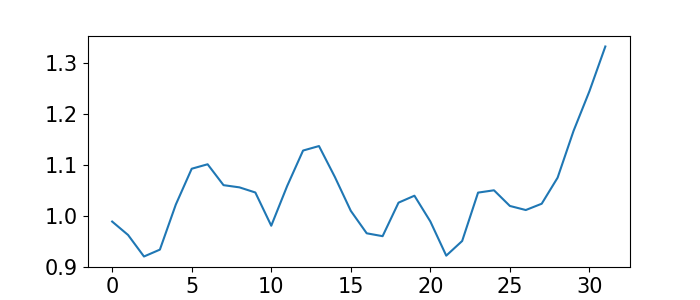

In [73]:
plt.plot( list(reversed(nrmse_arr)))

<IPython.core.display.Javascript object>


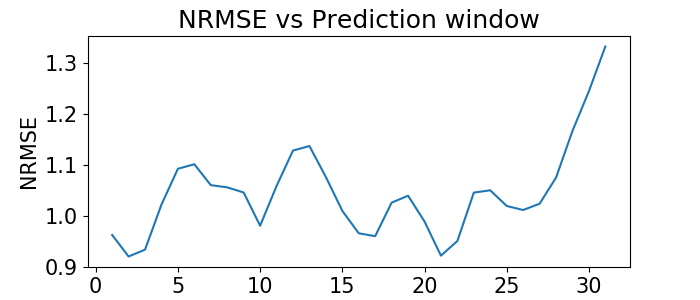

In [87]:
f = plt.figure(100)
plt.plot(range(1,32),list(reversed(nrmse_arr)) )
plt.xlabel('prediction window')
plt.ylabel('NRMSE')
plt.title("NRMSE vs Prediction window")
f.savefig("nrmsevspwrec.pdf", bbox_inches='tight')

In [74]:
# plt.rcParams["figure.figsize"] = (7,3)
f.savefig("nrmsevspwrec.pdf", bbox_inches='tight')

In [40]:
plt.xlabel('prediction window')

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]